# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
# run this if using a local machine
path = "path/to/this/folder"

where `path/to/this/folder` should contain another folder named `weights` which includes all the weights.

In [ ]:
# I used Google Colab, this will not work on another account or on a local machine
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/IsingModel/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to load all datasets
data = []
for i in range(30):
    data.append(np.load(path + 'sample_data/sample_'+str(i)+'.npy'))
data=np.array(data).astype("float32")
np.shape(data)

(30, 1001, 40, 40)

In [ ]:
# normalize data (min=-1, max=1), can be used on general, unnormalized datasets 
# (eg. generated configurations)

def normalize(arr):
    #return arr
    arr -= np.min(arr)
    arr = arr / np.max(arr)
    arr *= 2
    arr -= 1
    return arr

# Calculates the energy of each state in the dataset
def energy(data):
    configuration = normalize(data)
    gridsize = np.size(data,1)
    energy = np.zeros(np.size(data,0))
    for i in range(gridsize):
        for j in range(gridsize):
            spin = configuration[:,i,j]
            nearest_neighbors = configuration[:,(i+1)%gridsize, j] + configuration[:,i,(j+1)%gridsize] + configuration[:,(i-1)%gridsize, j] + configuration[:,i,(j-1)%gridsize]
            energy += -nearest_neighbors*spin
    return energy/2.

# Calculates the magnetization of each state in the dataset
def magnetization(data):
    configuration = normalize(data)
    magnetization = np.sum(np.sum(configuration,axis=2),axis=1)
    return magnetization


# Basic Datainterpretation

Let's first get familiar with the dataset, before diving into neural nets.

In [ ]:
# mean (over all configurations) energy for each temperature
energyM = [
    energy(i).mean() for i in data
]

# mean (over all configurations) magnetization for each temperature
magnetizationM = [
    magnetization(i).mean() for i in data
]

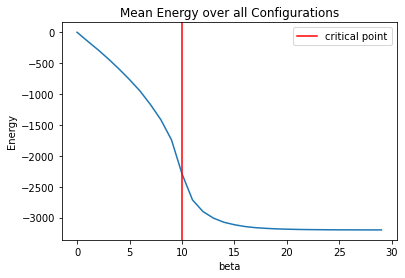

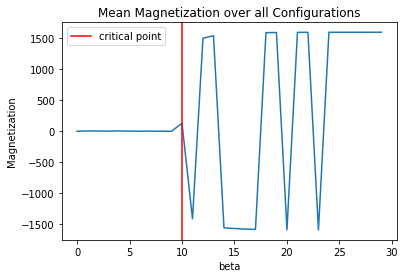

In [ ]:
plt.plot(energyM)
plt.title("Mean Energy over all Configurations")
plt.xlabel("beta")
plt.ylabel("Energy")
plt.axvline(10, color="r", label="critical point")
plt.legend()
plt.show()

plt.plot(magnetizationM)
plt.title("Mean Magnetization over all Configurations")
plt.xlabel("beta")
plt.ylabel("Magnetization")
plt.axvline(10, color="r", label="critical point")
plt.legend()
plt.show()

as one can see, with lower temperatures, the interactions between nearest neighbours become more and more important. Finally for extremly low temperatures, all spins point in the same direction (as one can see in the _mean magnetization_).

For higher temperatures, the spins are set "more random" and in the mean cancel each other out, which is why the magnetization vanishes.

It makes sense that the energy decreases with decreasing temperature.

---

Now let's consider only two temperatures. Thereby I choose $\beta=0.8\beta_c$ for high temperatures and $\beta=1.8\beta_c$ for low temperatures. I got the best results for those temperatures, I will later go into more detail about that.


In [ ]:
high_temperature = data[8]
low_temperature = data[19]

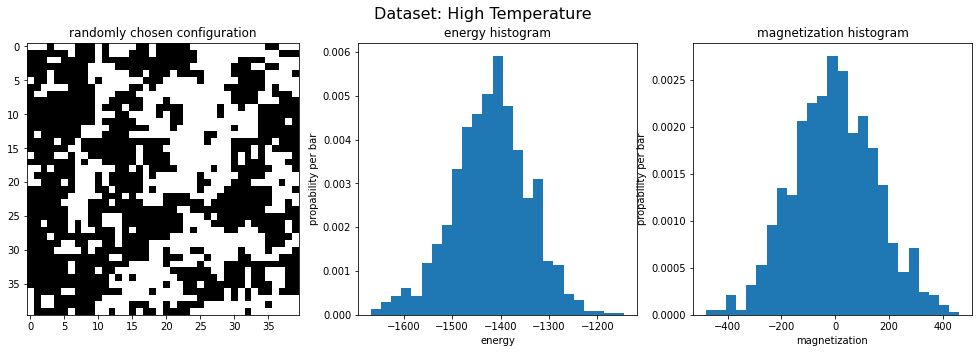

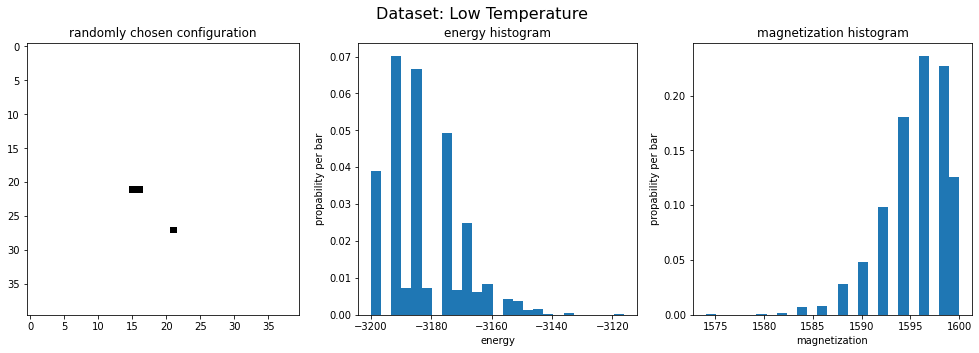

In [ ]:
# this defines a function which makes it easy to plot histograms of energy and 
# magnetization for any datasets. 
def overview_dataset(data):
    
    plt.subplot(1, 3, 1)
    plt.title("randomly chosen configuration")
    plt.imshow(data[np.random.randint(len(data))], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("energy histogram")
    plt.hist( energy(data), bins=25, density=True)
    plt.xlabel("energy")
    plt.ylabel("propability per bar")
    
    plt.subplot(1, 3, 3)
    plt.title("magnetization histogram")
    plt.hist( magnetization(data), bins=25, density=True)
    plt.xlabel("magnetization")
    plt.ylabel("propability per bar")

plt.figure(figsize=(17, 5))
plt.suptitle("Dataset: High Temperature", size=16)
overview_dataset(high_temperature)
plt.show()

plt.figure(figsize=(17, 5))
plt.suptitle("Dataset: Low Temperature", size=16)
overview_dataset(low_temperature)
plt.show()

In [ ]:
# check if data is normalized
print("max:", high_temperature.max())
print("min:", high_temperature.min())
print("mean:", high_temperature.mean())
print("std:", high_temperature.std())

max: 2.0
min: 0.0
mean: 0.99867135
std: 0.9999993


# Dataprepatration

I experienced bad performance using only 1001 different configurations during training, even more so when using subsets for training and testing. Therefore I wanted to augment data, to create new configurations that physically also make sense. Since the Ising Model only depends on the nearest neighbors, there is no restriction in orientation of the model. I therefore rotated all configurations for my data-augmentation. Another way for augmentation would be to flip the configurations horizontally and vertically, as this again would be possible physical Ising models.



In [ ]:
def generate_augmented_data(data):
    # create for each configuration three more configs, each rotated by 90 degrees
    new_data = np.array([
                         np.rot90(image, k) for image in data for k in range(4)
    ])
    return new_data

# augment both, high and low temperatures
augmented_low_temperature = generate_augmented_data(low_temperature)
augmented_high_temperature = generate_augmented_data(high_temperature)

In [ ]:
# Now let's only consider a subset of the newly created (augmentated) data.
# I chose for 80% of the data for training and 20% for possible testing

# LT_train, LT_test correspons to low temperature training set and low temperature testing set respectively
LT_train, LT_test = train_test_split(augmented_low_temperature, test_size = 0.2)

# HT_train, HT_test correspons to high temperature training set and high temperature testing set respectively
HT_train, HT_test = train_test_split(augmented_high_temperature, test_size = 0.2)

# Implementing and training GAN

My implementation of the GAN is based on the GAN introduced in the lecture _DCGAN.ipynb_ and on the GAN introduced https://www.tensorflow.org/tutorials/generative/dcgan. I implemented a class for for the GAN, so I could easily train for different datasets and also would be able to introduce some unique properties (eg. `training_data_history`)

In [ ]:
class GAN:

    def __init__(self, training_data, batch_size=128, epochs=100, noise_dim=100, num_examples_to_generate=16):

        self.training_data = np.array([training_data]).astype("float32")
        self.batch_size = batch_size
        self.epochs = epochs
        self.channels = 1 # we have one black/white images, not RGB or some time-dependent dataset
        self.noise_dim = noise_dim # noise_dim is set to 100 as it is also the size of the latent space
        self.num_examples_to_generate = num_examples_to_generate # just for neat plotting during training

        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


    def make_generator_model_Old(self):

        # the generator will create a configuration based on any latent space 
        # of dimension 10 * 10 (which could be interpretated as a two-dimensinoal
        # latent space)
        
        model = tf.keras.Sequential()
        model.add(layers.Dense(10*10*256, use_bias=False, input_shape=(100,)))  
        model.add(layers.BatchNormalization())              # normalizing, boosts performance of model
        model.add(layers.LeakyReLU())                       # negative values will be set to 0

        model.add(layers.Reshape((10, 10, 256)))
        assert model.output_shape == (None, 10, 10, 256)    # Note: None is the batch size

        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))  # Here the latent space increases, gets upscaled (sidelengths are doubled) and undergoes Conv2D
        assert model.output_shape == (None, 10, 10, 128)
        model.add(layers.BatchNormalization())              # repeat as above
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert model.output_shape == (None, 20, 20, 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # as above, but with activation="tanh" which sets very positive sites -> 1, very negative sites -> -1
        assert model.output_shape == (None, 40, 40, 1)

        return model

    def make_generator_model(self):

            # please refer to the comments of the WGAN, which uses the exact same generator.
            # I copied it from the WGAN to here as it showed better performance
            # Maybe the activation RELU works better for Ising Model than LeakyReLU does.
            # Or it helps to be more general starting with only 128 Nodes in the first layer

            model = Sequential()

            model.add(Dense(128 * 10 * 10, activation="relu", input_dim=100)) # <-- more general than make_generator_model_Old
            model.add(Reshape((10, 10, 128)))
            model.add(UpSampling2D())
            model.add(Conv2D(128, kernel_size=4, padding="same"))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Activation("relu"))
            model.add(UpSampling2D())
            model.add(Conv2D(64, kernel_size=4, padding="same"))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Activation("relu"))
            model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
            model.add(Activation("tanh"))

            return model

    def test_generator(self):
        # this function just shows the prove of concept
        # it creates a generator using the make_generator_model method and 
        # plots an genetrated configuration using untrained weights

        _generator = self.make_generator_model()

        noise = tf.random.normal([1, 100])
        _generated_image = _generator(noise, training = False)

        _discriminator = self.make_discriminator_model()
        decision = _discriminator(_generated_image)
        print(decision)
        print(_generated_image.shape)

        plt.imshow(_generated_image[0,:,:,0], cmap="gray")
        plt.show()

    def make_discriminator_model(self):
        # the discriminator tries do distinguish true configurations from fake/generated configurations

        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', # Conv2d layer tries to detect some important features (for distinguishing)
                                         input_shape=[40, 40, 1]))
        model.add(layers.LeakyReLU())                                       # this time I do use LeakyReLU, got good results
        model.add(layers.Dropout(0.3))                                      # encourages generalization

        # same procedure, but with more abstract features (based on the the previous Conv2D layer, not the original image/configuration)
        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1)) # finally only decide between "is fake" and "is real", thus only one perceptron is required

        return model

    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        # discriminator loss as defined in lecture
        def discriminator_loss(real_output, fake_output):
            real_loss = self.loss(tf.ones_like(real_output), real_output)
            fake_loss = self.loss(tf.zeros_like(fake_output), fake_output)
            total_loss = real_loss + fake_loss
            return total_loss

        # generator loss as defined in lecture
        def generator_loss(fake_output):
            return self.loss(tf.ones_like(fake_output), fake_output)


        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True) # check whether real configs are recognized as being real
            fake_output = self.discriminator(generated_images, training=True) # check wheter fake/generated configs are accordingly recognized

            # from that calculate loss
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        # calculate gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # update gradients
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return disc_loss, gen_loss # returned in order to update self.training_history

    def train(self, dataset=None, epochs=None):

        self.training_history = []

        # this give oppurtunity to train on a completly different or new dataset
        if not dataset:
            dataset = self.training_data

        # this lets you quickly change epochs
        if not epochs:
            epochs = self.epochs

        for epoch in range(epochs):
            start = time.time() # for benchmark

            for image_batch in dataset:
                d_loss, g_loss = self.train_step(image_batch)
            
            self.training_history.append([epoch, np.mean(d_loss), np.mean(g_loss)])

            if epoch % 20 == 0:
                self.generate_images()

            delta_time = time.time() - start
            time_per_epoch = delta_time / (epoch + 1)
            remaining_time = (self.epochs - epoch) * self.batch_size * time_per_epoch
            print("time for epoch {} is {} sec.\tEstimated Time: {} sec".format(epoch+1, delta_time, remaining_time))
        
        self.training_history = np.array(self.training_history)

    def generate_images(self):
        # this function just generates some random fake configurations, which let us give insight to the training.
        predictions = self.generator(tf.random.normal([self.num_examples_to_generate, self.noise_dim]), training=False)

        fig = plt.figure(figsize=(4,4))

        square_length = int(np.ceil(np.sqrt(self.num_examples_to_generate)))

        for i in range(predictions.shape[0]):
            plt.subplot(square_length, square_length, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.show()


In [ ]:
# setup two different GANs on the dataset we prepared (LT_train, HT_train)
# as explained in "Problems worth discussing", increaing batch_size to 256 helped significantly.
# after 225 I found the GAN to work reasonable good. Letting it train further
# could end in mode collapse or overfitting of the disciminator to the training data.
# One would need to adapt the architecture or the loss function methods encouraging generalization
gan_low_temp = GAN(LT_train, epochs=225, batch_size=256)
gan_high_temp = GAN(HT_train, epochs=225, batch_size=256) 

tf.Tensor([[0.00168123]], shape=(1, 1), dtype=float32)
(1, 40, 40, 1)


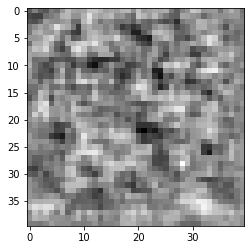

In [ ]:
gan_high_temp.test_generator()

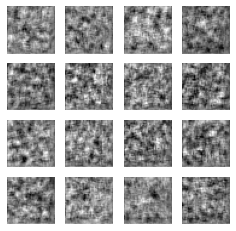

time for epoch 1 is 1.7812480926513672 sec.	Estimated Time: 102599.89013671875 sec
time for epoch 2 is 0.26981091499328613 sec.	Estimated Time: 7736.0185546875 sec
time for epoch 3 is 0.26929521560668945 sec.	Estimated Time: 5124.5084228515625 sec
time for epoch 4 is 0.26805996894836426 sec.	Estimated Time: 3808.5960388183594 sec
time for epoch 5 is 0.26755189895629883 sec.	Estimated Time: 3027.4032470703123 sec
time for epoch 6 is 0.27116823196411133 sec.	Estimated Time: 2545.3658040364585 sec
time for epoch 7 is 0.26938819885253906 sec.	Estimated Time: 2157.568568638393 sec
time for epoch 8 is 0.267566442489624 sec.	Estimated Time: 1866.5435028076172 sec
time for epoch 9 is 0.26682376861572266 sec.	Estimated Time: 1646.9548882378472 sec
time for epoch 10 is 0.26795077323913574 sec.	Estimated Time: 1481.660595703125 sec
time for epoch 11 is 0.26805925369262695 sec.	Estimated Time: 1341.2710293856535 sec
time for epoch 12 is 0.26781439781188965 sec.	Estimated Time: 1222.6619974772136 s

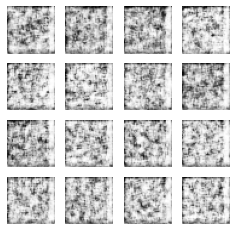

time for epoch 21 is 0.6326324939727783 sec.	Estimated Time: 1580.978727794829 sec
time for epoch 22 is 0.2683980464935303 sec.	Estimated Time: 637.1281627308239 sec
time for epoch 23 is 0.26677966117858887 sec.	Estimated Time: 602.7828448751698 sec
time for epoch 24 is 0.2686731815338135 sec.	Estimated Time: 578.9011484781901 sec
time for epoch 25 is 0.2691786289215088 sec.	Estimated Time: 554.0342211914062 sec
time for epoch 26 is 0.26754164695739746 sec.	Estimated Time: 526.8512432391826 sec
time for epoch 27 is 0.2682335376739502 sec.	Estimated Time: 506.10701271339695 sec
time for epoch 28 is 0.2706925868988037 sec.	Estimated Time: 490.03092302594865 sec
time for epoch 29 is 0.26749277114868164 sec.	Estimated Time: 465.1791529162177 sec
time for epoch 30 is 0.267467737197876 sec.	Estimated Time: 447.34870605468745 sec
time for epoch 31 is 0.268169641494751 sec.	Estimated Time: 431.83962914251515 sec
time for epoch 32 is 0.267650842666626 sec.	Estimated Time: 415.3941078186035 sec


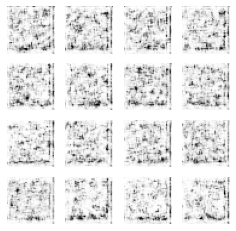

time for epoch 41 is 0.6184689998626709 sec.	Estimated Time: 714.4071178901487 sec
time for epoch 42 is 0.2717010974884033 sec.	Estimated Time: 304.71924990699404 sec
time for epoch 43 is 0.26763486862182617 sec.	Estimated Time: 291.58507733012357 sec
time for epoch 44 is 0.26746058464050293 sec.	Estimated Time: 283.2164445356889 sec
time for epoch 45 is 0.2676091194152832 sec.	Estimated Time: 275.55413682725697 sec
time for epoch 46 is 0.26837658882141113 sec.	Estimated Time: 268.84333071501356 sec
time for epoch 47 is 0.2682790756225586 sec.	Estimated Time: 261.56639066655583 sec
time for epoch 48 is 0.26783061027526855 sec.	Estimated Time: 254.2605260213216 sec
time for epoch 49 is 0.2675139904022217 sec.	Estimated Time: 247.3794680225606 sec
time for epoch 50 is 0.26933860778808594 sec.	Estimated Time: 242.70640625 sec
time for epoch 51 is 0.2680478096008301 sec.	Estimated Time: 235.46160529641546 sec
time for epoch 52 is 0.268294095993042 sec.	Estimated Time: 229.82485022911658 se

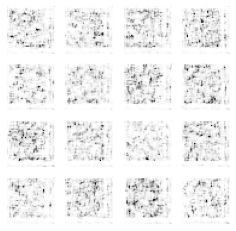

time for epoch 61 is 0.7551345825195312 sec.	Estimated Time: 522.8997502561475 sec
time for epoch 62 is 0.2691075801849365 sec.	Estimated Time: 182.22923623361893 sec
time for epoch 63 is 0.26740002632141113 sec.	Estimated Time: 177.11219521174354 sec
time for epoch 64 is 0.2673478126525879 sec.	Estimated Time: 173.24138259887695 sec
time for epoch 65 is 0.2679328918457031 sec.	Estimated Time: 169.89418569711538 sec
time for epoch 66 is 0.26724886894226074 sec.	Estimated Time: 165.85626775568184 sec
time for epoch 67 is 0.2669684886932373 sec.	Estimated Time: 162.18933378760494 sec
time for epoch 68 is 0.2689206600189209 sec.	Estimated Time: 159.96033612419578 sec
time for epoch 69 is 0.2668795585632324 sec.	Estimated Time: 155.45540895323822 sec
time for epoch 70 is 0.2674684524536133 sec.	Estimated Time: 152.59457310267857 sec
time for epoch 71 is 0.267719030380249 sec.	Estimated Time: 149.6210017674406 sec
time for epoch 72 is 0.26862287521362305 sec.	Estimated Time: 147.08594767252

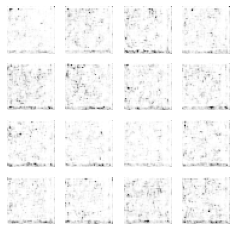

time for epoch 81 is 0.6218822002410889 sec.	Estimated Time: 284.9909539870274 sec
time for epoch 82 is 0.2695906162261963 sec.	Estimated Time: 121.19742044588415 sec
time for epoch 83 is 0.26751279830932617 sec.	Estimated Time: 117.98925928322666 sec
time for epoch 84 is 0.26717686653137207 sec.	Estimated Time: 115.62396966843379 sec
time for epoch 85 is 0.26746559143066406 sec.	Estimated Time: 113.58162339154411 sec
time for epoch 86 is 0.26870274543762207 sec.	Estimated Time: 111.98030693586483 sec
time for epoch 87 is 0.26708269119262695 sec.	Estimated Time: 109.23989061377515 sec
time for epoch 88 is 0.2671992778778076 sec.	Estimated Time: 107.26836464621805 sec
time for epoch 89 is 0.2671501636505127 sec.	Estimated Time: 105.27517460169416 sec
time for epoch 90 is 0.26703691482543945 sec.	Estimated Time: 103.30174696180556 sec
time for epoch 91 is 0.26982975006103516 sec.	Estimated Time: 102.4760017814217 sec
time for epoch 92 is 0.26780200004577637 sec.	Estimated Time: 99.855215

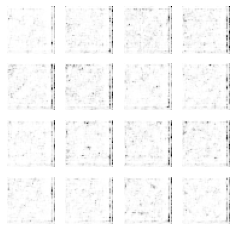

time for epoch 101 is 0.7398970127105713 sec.	Estimated Time: 234.4228159082998 sec
time for epoch 102 is 0.26870203018188477 sec.	Estimated Time: 83.62428672640931 sec
time for epoch 103 is 0.26831960678100586 sec.	Estimated Time: 82.02764833320691 sec
time for epoch 104 is 0.26809096336364746 sec.	Estimated Time: 80.50977853628306 sec
time for epoch 105 is 0.26759862899780273 sec.	Estimated Time: 78.94414411272321 sec
time for epoch 106 is 0.26758742332458496 sec.	Estimated Time: 77.54986457104953 sec
time for epoch 107 is 0.26733970642089844 sec.	Estimated Time: 76.11436277015187 sec
time for epoch 108 is 0.2671053409576416 sec.	Estimated Time: 74.71035314489295 sec
time for epoch 109 is 0.2684924602508545 sec.	Estimated Time: 73.77877219663847 sec
time for epoch 110 is 0.268601655960083 sec.	Estimated Time: 72.5126797762784 sec
time for epoch 111 is 0.26935744285583496 sec.	Estimated Time: 71.44038844752957 sec
time for epoch 112 is 0.26764559745788574 sec.	Estimated Time: 69.74079

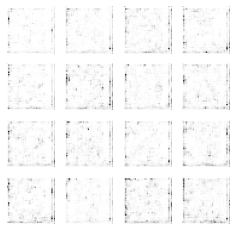

time for epoch 121 is 0.6174769401550293 sec.	Estimated Time: 137.17173678815857 sec
time for epoch 122 is 0.27001380920410156 sec.	Estimated Time: 58.92498078893443 sec
time for epoch 123 is 0.26749110221862793 sec.	Estimated Time: 57.343133197567326 sec
time for epoch 124 is 0.2680501937866211 sec.	Estimated Time: 56.446182743195564 sec
time for epoch 125 is 0.26973915100097656 sec.	Estimated Time: 55.795003906249995 sec
time for epoch 126 is 0.26905393600463867 sec.	Estimated Time: 54.66492668030754 sec
time for epoch 127 is 0.26994991302490234 sec.	Estimated Time: 53.870949572465555 sec
time for epoch 128 is 0.26871752738952637 sec.	Estimated Time: 52.66863536834717 sec
time for epoch 129 is 0.2686314582824707 sec.	Estimated Time: 51.71051451217297 sec
time for epoch 130 is 0.2683596611022949 sec.	Estimated Time: 50.732361778846155 sec
time for epoch 131 is 0.26825428009033203 sec.	Estimated Time: 49.80109993738073 sec
time for epoch 132 is 0.2704122066497803 sec.	Estimated Time: 4

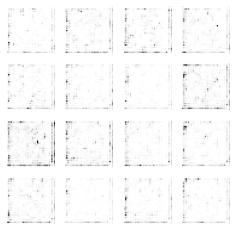

time for epoch 141 is 0.6137571334838867 sec.	Estimated Time: 94.71883138020833 sec
time for epoch 142 is 0.2713792324066162 sec.	Estimated Time: 41.09675361740757 sec
time for epoch 143 is 0.26868152618408203 sec.	Estimated Time: 39.9226927857299 sec
time for epoch 144 is 0.26877379417419434 sec.	Estimated Time: 39.18124643961589 sec
time for epoch 145 is 0.26888489723205566 sec.	Estimated Time: 38.45239468278556 sec
time for epoch 146 is 0.269120454788208 sec.	Estimated Time: 37.750595301797944 sec
time for epoch 147 is 0.2686161994934082 sec.	Estimated Time: 36.95574162282101 sec
time for epoch 148 is 0.2681279182434082 sec.	Estimated Time: 36.17552886138091 sec
time for epoch 149 is 0.2689518928527832 sec.	Estimated Time: 35.58107189204069 sec
time for epoch 150 is 0.26903486251831055 sec.	Estimated Time: 34.895615234375 sec
time for epoch 151 is 0.268787145614624 sec.	Estimated Time: 34.17690858146213 sec
time for epoch 152 is 0.26822686195373535 sec.	Estimated Time: 33.4295373213

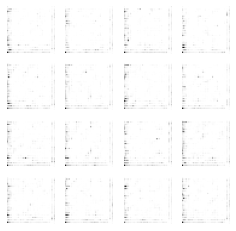

time for epoch 161 is 0.7624304294586182 sec.	Estimated Time: 78.8002630198224 sec
time for epoch 162 is 0.26988816261291504 sec.	Estimated Time: 27.29535590277778 sec
time for epoch 163 is 0.2679898738861084 sec.	Estimated Time: 26.516200527823045 sec
time for epoch 164 is 0.2671680450439453 sec.	Estimated Time: 25.85665372522866 sec
time for epoch 165 is 0.2669084072113037 sec.	Estimated Time: 25.260858709161933 sec
time for epoch 166 is 0.26812267303466797 sec.	Estimated Time: 24.809423239834338 sec
time for epoch 167 is 0.26807308197021484 sec.	Estimated Time: 24.24536425196482 sec
time for epoch 168 is 0.2681756019592285 sec.	Estimated Time: 23.701615106491815 sec
time for epoch 169 is 0.26762962341308594 sec.	Estimated Time: 23.10799683339497 sec
time for epoch 170 is 0.2684967517852783 sec.	Estimated Time: 22.642173138786767 sec
time for epoch 171 is 0.2677731513977051 sec.	Estimated Time: 22.04822205660636 sec
time for epoch 172 is 0.2677028179168701 sec.	Estimated Time: 21.515

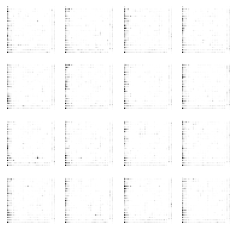

time for epoch 181 is 0.6097736358642578 sec.	Estimated Time: 38.80990212793508 sec
time for epoch 182 is 0.2694361209869385 sec.	Estimated Time: 16.675431136246566 sec
time for epoch 183 is 0.26745009422302246 sec.	Estimated Time: 16.087926979273394 sec
time for epoch 184 is 0.2679409980773926 sec.	Estimated Time: 15.657073974609375 sec
time for epoch 185 is 0.2674851417541504 sec.	Estimated Time: 15.1758056640625 sec
time for epoch 186 is 0.2674417495727539 sec.	Estimated Time: 14.723674815188172 sec
time for epoch 187 is 0.2673313617706299 sec.	Estimated Time: 14.272921475497158 sec
time for epoch 188 is 0.26671719551086426 sec.	Estimated Time: 13.801196159200465 sec
time for epoch 189 is 0.2674851417541504 sec.	Estimated Time: 13.405392924313823 sec
time for epoch 190 is 0.27137184143066406 sec.	Estimated Time: 13.162962582236842 sec
time for epoch 191 is 0.26851415634155273 sec.	Estimated Time: 12.5962661823053 sec
time for epoch 192 is 0.26747822761535645 sec.	Estimated Time: 12.

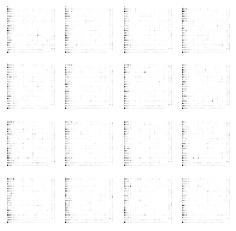

time for epoch 201 is 0.6017632484436035 sec.	Estimated Time: 19.160620845965486 sec
time for epoch 202 is 0.26877474784851074 sec.	Estimated Time: 8.175010152382425 sec
time for epoch 203 is 0.26936769485473633 sec.	Estimated Time: 7.812990085244766 sec
time for epoch 204 is 0.2673773765563965 sec.	Estimated Time: 7.381712670419731 sec
time for epoch 205 is 0.2672443389892578 sec.	Estimated Time: 7.008319836128049 sec
time for epoch 206 is 0.26786065101623535 sec.	Estimated Time: 6.657507442733617 sec
time for epoch 207 is 0.2695503234863281 sec.	Estimated Time: 6.333781514190822 sec
time for epoch 208 is 0.2667210102081299 sec.	Estimated Time: 5.90889622614934 sec
time for epoch 209 is 0.26753664016723633 sec.	Estimated Time: 5.570906497645036 sec
time for epoch 210 is 0.2682459354400635 sec.	Estimated Time: 5.232073102678571 sec
time for epoch 211 is 0.26805710792541504 sec.	Estimated Time: 4.8783852816758 sec
time for epoch 212 is 0.26778626441955566 sec.	Estimated Time: 4.52710363

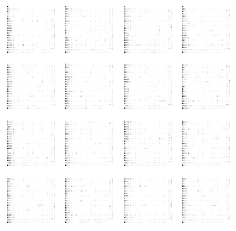

time for epoch 221 is 0.7716164588928223 sec.	Estimated Time: 4.469090802637161 sec
time for epoch 222 is 0.2693607807159424 sec.	Estimated Time: 1.2424569344735361 sec
time for epoch 223 is 0.26776742935180664 sec.	Estimated Time: 0.9221766176779709 sec
time for epoch 224 is 0.2687230110168457 sec.	Estimated Time: 0.6142240251813617 sec
time for epoch 225 is 0.2699708938598633 sec.	Estimated Time: 0.30716688368055556 sec


In [ ]:
# now lets train the gan for low temperatures. During training one can see 
# some samples of the generator
gan_low_temp.train()

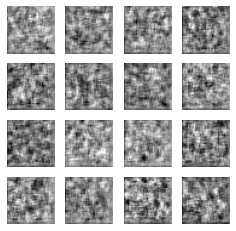

time for epoch 1 is 0.6805980205535889 sec.	Estimated Time: 39202.44598388672 sec
time for epoch 2 is 0.27001285552978516 sec.	Estimated Time: 7741.80859375 sec
time for epoch 3 is 0.2683398723602295 sec.	Estimated Time: 5106.328877766927 sec
time for epoch 4 is 0.26862335205078125 sec.	Estimated Time: 3816.6005859375 sec
time for epoch 5 is 0.2689931392669678 sec.	Estimated Time: 3043.7111694335936 sec
time for epoch 6 is 0.26923108100891113 sec.	Estimated Time: 2527.182413736979 sec
time for epoch 7 is 0.26778268814086914 sec.	Estimated Time: 2144.7098039899556 sec
time for epoch 8 is 0.2686591148376465 sec.	Estimated Time: 1874.1659851074219 sec
time for epoch 9 is 0.268887996673584 sec.	Estimated Time: 1659.6962212456597 sec
time for epoch 10 is 0.2675461769104004 sec.	Estimated Time: 1479.42333984375 sec
time for epoch 11 is 0.26804590225219727 sec.	Estimated Time: 1341.2042236328125 sec
time for epoch 12 is 0.2675650119781494 sec.	Estimated Time: 1221.5234680175781 sec
time for e

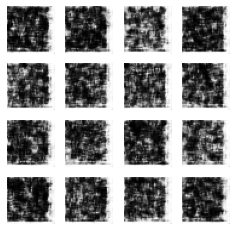

time for epoch 21 is 0.6037425994873047 sec.	Estimated Time: 1508.781505766369 sec
time for epoch 22 is 0.26958799362182617 sec.	Estimated Time: 639.952880859375 sec
time for epoch 23 is 0.26732683181762695 sec.	Estimated Time: 604.0191650390625 sec
time for epoch 24 is 0.2673158645629883 sec.	Estimated Time: 575.9765828450521 sec
time for epoch 25 is 0.26755356788635254 sec.	Estimated Time: 550.6894555664063 sec
time for epoch 26 is 0.26776957511901855 sec.	Estimated Time: 527.3000863882212 sec
time for epoch 27 is 0.26924824714660645 sec.	Estimated Time: 508.0215815791378 sec
time for epoch 28 is 0.26921606063842773 sec.	Estimated Time: 487.3579886300223 sec
time for epoch 29 is 0.26706528663635254 sec.	Estimated Time: 464.43574260843207 sec
time for epoch 30 is 0.2667989730834961 sec.	Estimated Time: 446.23017578124995 sec
time for epoch 31 is 0.2681300640106201 sec.	Estimated Time: 431.77589662613406 sec
time for epoch 32 is 0.2679166793823242 sec.	Estimated Time: 415.8066864013672

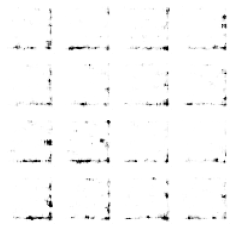

time for epoch 41 is 0.7565178871154785 sec.	Estimated Time: 873.8704178972941 sec
time for epoch 42 is 0.2687532901763916 sec.	Estimated Time: 301.4132138206845 sec
time for epoch 43 is 0.26701807975769043 sec.	Estimated Time: 290.91309303461117 sec
time for epoch 44 is 0.26845264434814453 sec.	Estimated Time: 284.26694557883525 sec
time for epoch 45 is 0.2673821449279785 sec.	Estimated Time: 275.320423719618 sec
time for epoch 46 is 0.2673501968383789 sec.	Estimated Time: 267.8151537024456 sec
time for epoch 47 is 0.2678511142730713 sec.	Estimated Time: 261.14913745636636 sec
time for epoch 48 is 0.26776599884033203 sec.	Estimated Time: 254.19918823242188 sec
time for epoch 49 is 0.26804518699645996 sec.	Estimated Time: 247.87068394252233 sec
time for epoch 50 is 0.2672586441040039 sec.	Estimated Time: 240.832109375 sec
time for epoch 51 is 0.26732921600341797 sec.	Estimated Time: 234.83037013633577 sec
time for epoch 52 is 0.26807117462158203 sec.	Estimated Time: 229.6338923527644 s

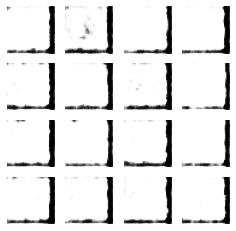

time for epoch 61 is 0.6157166957855225 sec.	Estimated Time: 426.3585775406634 sec
time for epoch 62 is 0.2689170837402344 sec.	Estimated Time: 182.1002394153226 sec
time for epoch 63 is 0.2673525810241699 sec.	Estimated Time: 177.08076985677081 sec
time for epoch 64 is 0.2674887180328369 sec.	Estimated Time: 173.33268928527832 sec
time for epoch 65 is 0.26773548126220703 sec.	Estimated Time: 169.76900916466346 sec
time for epoch 66 is 0.26833653450012207 sec.	Estimated Time: 166.53127959280306 sec
time for epoch 67 is 0.26744699478149414 sec.	Estimated Time: 162.48003694904384 sec
time for epoch 68 is 0.26717591285705566 sec.	Estimated Time: 158.92251945944392 sec
time for epoch 69 is 0.2679407596588135 sec.	Estimated Time: 156.0735509015512 sec
time for epoch 70 is 0.26800537109375 sec.	Estimated Time: 152.90089285714285 sec
time for epoch 71 is 0.26750731468200684 sec.	Estimated Time: 149.50267952932438 sec
time for epoch 72 is 0.2679331302642822 sec.	Estimated Time: 146.70827399359

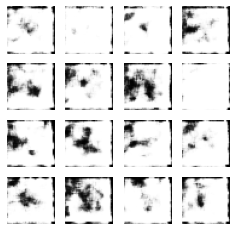

time for epoch 81 is 0.6045808792114258 sec.	Estimated Time: 277.06224983121143 sec
time for epoch 82 is 0.26849794387817383 sec.	Estimated Time: 120.70619759908536 sec
time for epoch 83 is 0.2695755958557129 sec.	Estimated Time: 118.89907726609563 sec
time for epoch 84 is 0.2679436206817627 sec.	Estimated Time: 115.95579165504093 sec
time for epoch 85 is 0.26812171936035156 sec.	Estimated Time: 113.86025390625 sec
time for epoch 86 is 0.26775312423706055 sec.	Estimated Time: 111.58455782158431 sec
time for epoch 87 is 0.26785826683044434 sec.	Estimated Time: 109.55710996430496 sec
time for epoch 88 is 0.2690262794494629 sec.	Estimated Time: 108.00182273171164 sec
time for epoch 89 is 0.26816749572753906 sec.	Estimated Time: 105.67607202422754 sec
time for epoch 90 is 0.2676360607147217 sec.	Estimated Time: 103.53352322048612 sec
time for epoch 91 is 0.2674119472503662 sec.	Estimated Time: 101.55776809860062 sec
time for epoch 92 is 0.2678108215332031 sec.	Estimated Time: 99.8585045855

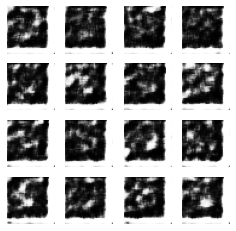

time for epoch 101 is 0.7889184951782227 sec.	Estimated Time: 249.95437470993193 sec
time for epoch 102 is 0.26880550384521484 sec.	Estimated Time: 83.65648935355392 sec
time for epoch 103 is 0.27010083198547363 sec.	Estimated Time: 82.57218444231646 sec
time for epoch 104 is 0.2730700969696045 sec.	Estimated Time: 82.00505065917969 sec
time for epoch 105 is 0.2684814929962158 sec.	Estimated Time: 79.20459740048364 sec
time for epoch 106 is 0.26763391494750977 sec.	Estimated Time: 77.5633383696934 sec
time for epoch 107 is 0.2690389156341553 sec.	Estimated Time: 76.59814510167202 sec
time for epoch 108 is 0.26871418952941895 sec.	Estimated Time: 75.16035404911749 sec
time for epoch 109 is 0.26828455924987793 sec.	Estimated Time: 73.72164329038847 sec
time for epoch 110 is 0.26836490631103516 sec.	Estimated Time: 72.44876598011363 sec
time for epoch 111 is 0.2678375244140625 sec.	Estimated Time: 71.03726773648648 sec
time for epoch 112 is 0.2690134048461914 sec.	Estimated Time: 70.09720

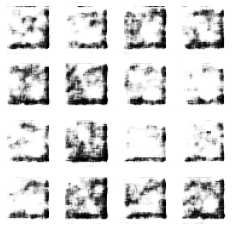

time for epoch 121 is 0.6148238182067871 sec.	Estimated Time: 136.5823490363507 sec
time for epoch 122 is 0.26990175247192383 sec.	Estimated Time: 58.90052670338115 sec
time for epoch 123 is 0.2679924964904785 sec.	Estimated Time: 57.45061908504827 sec
time for epoch 124 is 0.2681405544281006 sec.	Estimated Time: 56.4652109453755 sec
time for epoch 125 is 0.2677161693572998 sec.	Estimated Time: 55.37655419921875 sec
time for epoch 126 is 0.2674388885498047 sec.	Estimated Time: 54.33679005456349 sec
time for epoch 127 is 0.26747560501098633 sec.	Estimated Time: 53.3771790031373 sec
time for epoch 128 is 0.2680642604827881 sec.	Estimated Time: 52.540595054626465 sec
time for epoch 129 is 0.26705074310302734 sec.	Estimated Time: 51.40623296693314 sec
time for epoch 130 is 0.2678184509277344 sec.	Estimated Time: 50.630048076923075 sec
time for epoch 131 is 0.26760196685791016 sec.	Estimated Time: 49.67999873270516 sec
time for epoch 132 is 0.269303560256958 sec.	Estimated Time: 49.09485510

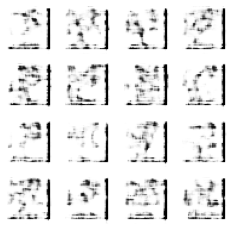

time for epoch 141 is 0.6067526340484619 sec.	Estimated Time: 93.63785331130873 sec
time for epoch 142 is 0.2691178321838379 sec.	Estimated Time: 40.75429481183979 sec
time for epoch 143 is 0.26877570152282715 sec.	Estimated Time: 39.93668605564358 sec
time for epoch 144 is 0.26975345611572266 sec.	Estimated Time: 39.324059380425346 sec
time for epoch 145 is 0.26886940002441406 sec.	Estimated Time: 38.450178475215516 sec
time for epoch 146 is 0.2681269645690918 sec.	Estimated Time: 37.61123448202055 sec
time for epoch 147 is 0.26774048805236816 sec.	Estimated Time: 36.83526279164009 sec
time for epoch 148 is 0.26781749725341797 sec.	Estimated Time: 36.13364719700169 sec
time for epoch 149 is 0.2692830562591553 sec.	Estimated Time: 35.62488325490247 sec
time for epoch 150 is 0.26800966262817383 sec.	Estimated Time: 34.762639973958336 sec
time for epoch 151 is 0.2681303024291992 sec.	Estimated Time: 34.09338944795116 sec
time for epoch 152 is 0.26767921447753906 sec.	Estimated Time: 33.3

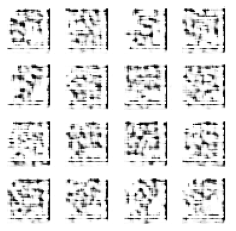

time for epoch 161 is 0.7673580646514893 sec.	Estimated Time: 79.30955401118497 sec
time for epoch 162 is 0.2725663185119629 sec.	Estimated Time: 27.566213348765434 sec
time for epoch 163 is 0.2677948474884033 sec.	Estimated Time: 26.49690368277895 sec
time for epoch 164 is 0.26789093017578125 sec.	Estimated Time: 25.926614900914632 sec
time for epoch 165 is 0.26713061332702637 sec.	Estimated Time: 25.281888834635414 sec
time for epoch 166 is 0.26752424240112305 sec.	Estimated Time: 24.754050381212352 sec
time for epoch 167 is 0.26775670051574707 sec.	Estimated Time: 24.216749728082895 sec
time for epoch 168 is 0.2675497531890869 sec.	Estimated Time: 23.646301996140252 sec
time for epoch 169 is 0.2688310146331787 sec.	Estimated Time: 23.211728790102626 sec
time for epoch 170 is 0.26930832862854004 sec.	Estimated Time: 22.710612936580883 sec
time for epoch 171 is 0.26829004287719727 sec.	Estimated Time: 22.09078247784174 sec
time for epoch 172 is 0.26779961585998535 sec.	Estimated Time:

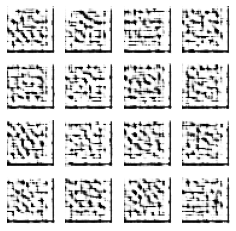

time for epoch 181 is 0.604006290435791 sec.	Estimated Time: 38.44283130287466 sec
time for epoch 182 is 0.26935243606567383 sec.	Estimated Time: 16.67025186727335 sec
time for epoch 183 is 0.26755762100219727 sec.	Estimated Time: 16.094395038208674 sec
time for epoch 184 is 0.2709643840789795 sec.	Estimated Time: 15.833744878354281 sec
time for epoch 185 is 0.26728010177612305 sec.	Estimated Time: 15.164172693201014 sec
time for epoch 186 is 0.26755690574645996 sec.	Estimated Time: 14.73001459593414 sec
time for epoch 187 is 0.26882433891296387 sec.	Estimated Time: 14.35263208399482 sec
time for epoch 188 is 0.2674281597137451 sec.	Estimated Time: 13.837984774975066 sec
time for epoch 189 is 0.2677440643310547 sec.	Estimated Time: 13.418369192294975 sec
time for epoch 190 is 0.26761722564697266 sec.	Estimated Time: 12.980843955592107 sec
time for epoch 191 is 0.26781272888183594 sec.	Estimated Time: 12.56336152241492 sec
time for epoch 192 is 0.2679023742675781 sec.	Estimated Time: 12

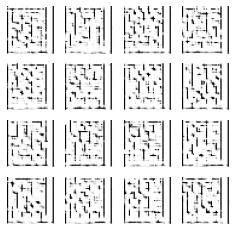

time for epoch 201 is 0.6098058223724365 sec.	Estimated Time: 19.416702801908425 sec
time for epoch 202 is 0.26929473876953125 sec.	Estimated Time: 8.190826113861387 sec
time for epoch 203 is 0.2672450542449951 sec.	Estimated Time: 7.751423051204587 sec
time for epoch 204 is 0.26808881759643555 sec.	Estimated Time: 7.401354023054534 sec
time for epoch 205 is 0.26748180389404297 sec.	Estimated Time: 7.014547208460367 sec
time for epoch 206 is 0.26772212982177734 sec.	Estimated Time: 6.654064585861651 sec
time for epoch 207 is 0.26791834831237793 sec.	Estimated Time: 6.295434039572011 sec
time for epoch 208 is 0.2679283618927002 sec.	Estimated Time: 5.935643709622896 sec
time for epoch 209 is 0.2680385112762451 sec.	Estimated Time: 5.581356942938846 sec
time for epoch 210 is 0.26788806915283203 sec.	Estimated Time: 5.225093005952381 sec
time for epoch 211 is 0.2684011459350586 sec.	Estimated Time: 4.884646447348933 sec
time for epoch 212 is 0.26919102668762207 sec.	Estimated Time: 4.5508

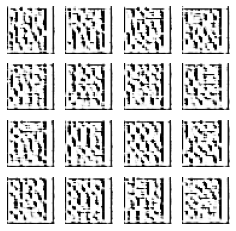

time for epoch 221 is 0.756873369216919 sec.	Estimated Time: 4.383700961980345 sec
time for epoch 222 is 0.26987147331237793 sec.	Estimated Time: 1.2448125615850225 sec
time for epoch 223 is 0.2679893970489502 sec.	Estimated Time: 0.9229410624824832 sec
time for epoch 224 is 0.26730799674987793 sec.	Estimated Time: 0.6109897068568638 sec
time for epoch 225 is 0.2693593502044678 sec.	Estimated Time: 0.3064710828993056 sec


In [ ]:
# now lets also train the gan for high temperatures
gan_high_temp.train()

In [ ]:
# save weights

# weights of the generator
gan_low_temp.generator.save_weights(path + "weights/gan_low_temp_generator")
# weights of the discriminator
gan_low_temp.discriminator.save_weights(path + "weights/gan_low_temp_discriminator")

gan_high_temp.generator.save_weights(path + "weights/gan_high_temp_generator")
gan_high_temp.discriminator.save_weights(path + "weights/gan_high_temp_discriminator")

In [ ]:
# load weights
# sidemark: note that all the weights must be in the folder 'weights' so that they 
# can be loaded properly.

gan_low_temp.generator.load_weights(path + "weights/gan_low_temp_generator")
gan_low_temp.discriminator.load_weights(path + "weights/gan_low_temp_discriminator")

gan_high_temp.generator.load_weights(path + "weights/gan_high_temp_generator")
gan_high_temp.discriminator.load_weights(path + "weights/gan_high_temp_discriminator")

In [ ]:
# function to calculate the mean magnetization and mean energy of both, the generator and the trainingdata
def print_properties(gan, trainingData):

    noise = tf.random.normal([2001, 100]) # noise for latent space
    generated_image = gan.generator(noise, training=False) # generated images
        
    print("mean: magnetization generated:", np.array(magnetization(generated_image)).mean())
    print("mean: magnetization from trainingdata:", magnetization(trainingData).mean())
    
    print("mean: energy from generated ising system:", np.array(energy(generated_image)).mean())
    print("mean: energy from trainingdata:", energy(trainingData).mean())
        
    print("std: magnetization generated:", np.array(magnetization(generated_image)).std())
    print("std: magnetization from trainingdata:", magnetization(trainingData).std())
    
    print("std: energy from generated ising system:", np.array(energy(generated_image)).std())
    print("std: energy from trainingdata:", energy(trainingData).std())

# this function just plots for a given generator two histograms, one for the
# energy distribution and one for the magnetization as well as a randomly
# generated configuration
def overview_generator(generator):
    noise = tf.random.normal([2001, 100]) # noise for latent space
    generated_image = generator(noise, training=False) # generated images
    
    plt.subplot(1, 3, 1)
    plt.title("randomly generated configuration")
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    
    _energy = energy(generated_image[:,:,:,0])
    plt.subplot(1, 3, 2)
    plt.title("energy histogram")
    plt.hist( _energy, bins=25, density=True)
    plt.xlabel("energy")
    plt.ylabel("propability per bar")
    
    _magnetization = magnetization(generated_image[:,:,:,0])
    plt.subplot(1, 3, 3)
    plt.title("magnetization histogram")
    plt.hist( _magnetization, bins=25, density=True)
    plt.xlabel("magnetization")
    plt.ylabel("propability per bar")
    


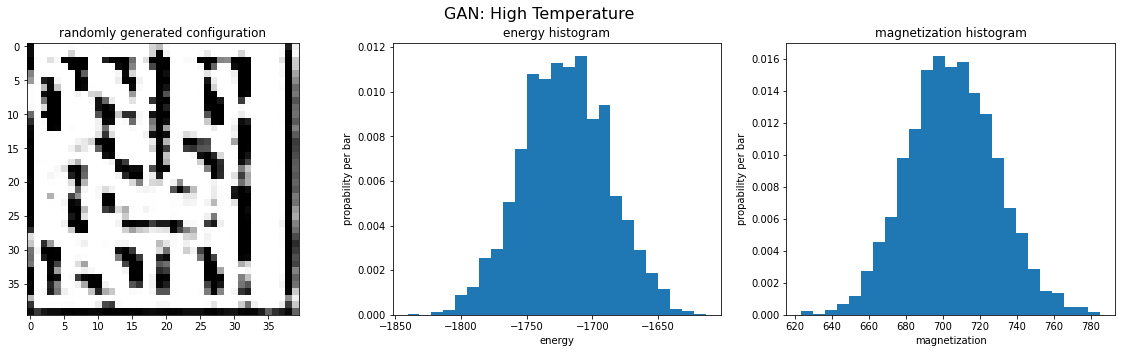

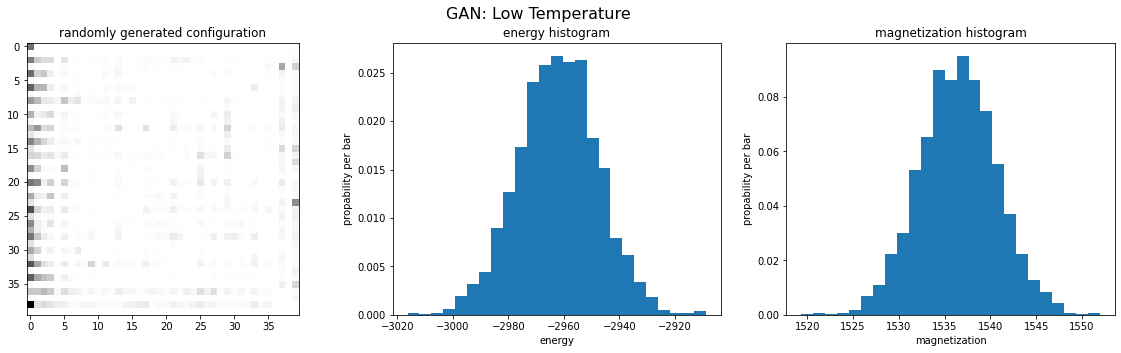

In [ ]:
# let's quickly plot the distributions for the trained GAN at low and at high
# temperatures. I will discuss the results in more depth later.

plt.figure(figsize=(20, 5))
plt.suptitle("GAN: High Temperature", size=16)
overview_generator(gan_high_temp.generator)
plt.show()

plt.figure(figsize=(20, 5))
plt.suptitle("GAN: Low Temperature", size=16)
overview_generator(gan_low_temp.generator)
plt.show()


# Implementing and training WGAN

Again, this implementation of WGAN is based on the WGAN.ipynb introduced in the lecture. I optimized hyperparamters and introduced `training_history` for further interpretation.

In [ ]:

class WGAN():
    def __init__(self, training_data):
        self.training_data = training_data
        self.img_rows = 40 # image/lattice height
        self.img_cols = 40 # image/lattice width
        self.channels = 1 # we have one black/white images, not RGB or some time-dependent dataset
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 # found that to be a usefull latent-space-size for good performance

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.005
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred) # the key difference to the normal GAN

    def build_generator(self):

        # the generator will create a configuration based on any latent space 
        # of dimension 10 * 10 (which could be interpretated as a two-dimensinoal
        # latent space)

        model = Sequential()

        model.add(Dense(128 * 10 * 10, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((10, 10, 128)))
        model.add(UpSampling2D())                                   # Here the latent space increases, gets upscaled (sidelengths are doubled)
        model.add(Conv2D(128, kernel_size=4, padding="same"))       # the upsampled latentspace undergoes Conv2D to best trick Critic
        model.add(BatchNormalization(momentum=0.8))                 # normalizing, boosts performance of model
        model.add(Activation("relu"))                               # negative values will be set to 0
        model.add(UpSampling2D())                                   # repeat from above ...
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same")) # finally another Conv2D layer, which will  ultimatly set the spins
        model.add(Activation("tanh"))                               # very positive sites -> 1, very negative sites -> -1

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)



    def build_critic(self):

        model = Sequential()

        # here we want to introduce x which makes adaption to more complex datasets more easily.
        # by complex I mean with very abstract patterns/features. In my case, I found 2 to be sufficient
        x=2 
        
        model.add(Conv2D(x*16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")) # Conv2d layer tries to detect some important features (for distinguishing)
        model.add(LeakyReLU(alpha=0.2))     # this time I do use LeakyReLU, got good results
        model.add(Dropout(0.25))            # encourages generalization
        model.add(Conv2D(x*32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8)) # better traininag
        model.add(LeakyReLU(alpha=0.2)) # repeat...
        model.add(Dropout(0.25))
        model.add(Conv2D(x*64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1)) # finally only decide between "is fake" and "is real", thus only one perceptron is required


        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        self.training_history = []

        # Load the dataset
        X_train = np.copy(self.training_data)

        # change data type 
        X_train = (X_train.astype(np.float32))
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            self.critic.trainable = True
            for c in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            #self.critic.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)

            self.training_history.append([
                                            epoch, d_loss[0], g_loss
            ])
            # Plot the progress
            #print(epoch)
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        
        self.training_history = np.array(self.training_history)

    def sample_images(self, epoch=None):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/wgan_mnist_%d.png" % epoch)
        plt.show()


In [ ]:
# let's define again two WGANs for both, low and high temperature
wgan_low_temp = WGAN(LT_train)
wgan_high_temp = WGAN(HT_train)

0 [D loss: 0.999890] [G loss: 1.000225]


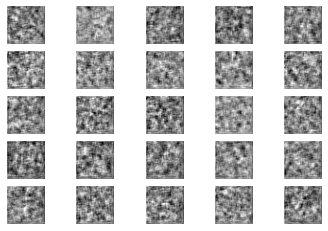

1 [D loss: 0.999897] [G loss: 1.000217]
2 [D loss: 0.999900] [G loss: 1.000219]
3 [D loss: 0.999898] [G loss: 1.000213]
4 [D loss: 0.999895] [G loss: 1.000216]
5 [D loss: 0.999896] [G loss: 1.000212]
6 [D loss: 0.999896] [G loss: 1.000213]
7 [D loss: 0.999898] [G loss: 1.000214]
8 [D loss: 0.999899] [G loss: 1.000199]
9 [D loss: 0.999900] [G loss: 1.000195]
10 [D loss: 0.999902] [G loss: 1.000192]
11 [D loss: 0.999905] [G loss: 1.000181]
12 [D loss: 0.999910] [G loss: 1.000170]
13 [D loss: 0.999916] [G loss: 1.000153]
14 [D loss: 0.999924] [G loss: 1.000134]
15 [D loss: 0.999933] [G loss: 1.000115]
16 [D loss: 0.999940] [G loss: 1.000098]
17 [D loss: 0.999948] [G loss: 1.000082]
18 [D loss: 0.999956] [G loss: 1.000079]
19 [D loss: 0.999961] [G loss: 1.000072]
20 [D loss: 0.999960] [G loss: 1.000071]
21 [D loss: 0.999965] [G loss: 1.000069]
22 [D loss: 0.999969] [G loss: 1.000067]
23 [D loss: 0.999969] [G loss: 1.000065]
24 [D loss: 0.999971] [G loss: 1.000065]
25 [D loss: 0.999970] [G 

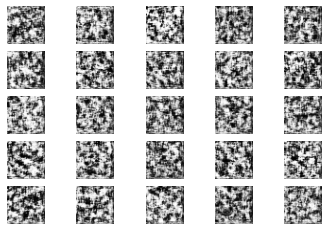

33 [D loss: 0.999969] [G loss: 1.000064]
34 [D loss: 0.999970] [G loss: 1.000065]
35 [D loss: 0.999970] [G loss: 1.000065]
36 [D loss: 0.999970] [G loss: 1.000064]
37 [D loss: 0.999971] [G loss: 1.000063]
38 [D loss: 0.999967] [G loss: 1.000065]
39 [D loss: 0.999971] [G loss: 1.000064]
40 [D loss: 0.999970] [G loss: 1.000065]
41 [D loss: 0.999971] [G loss: 1.000065]
42 [D loss: 0.999969] [G loss: 1.000062]
43 [D loss: 0.999971] [G loss: 1.000063]
44 [D loss: 0.999970] [G loss: 1.000062]
45 [D loss: 0.999970] [G loss: 1.000065]
46 [D loss: 0.999971] [G loss: 1.000064]
47 [D loss: 0.999968] [G loss: 1.000067]
48 [D loss: 0.999971] [G loss: 1.000063]
49 [D loss: 0.999970] [G loss: 1.000067]
50 [D loss: 0.999970] [G loss: 1.000067]
51 [D loss: 0.999971] [G loss: 1.000065]
52 [D loss: 0.999968] [G loss: 1.000062]
53 [D loss: 0.999971] [G loss: 1.000065]
54 [D loss: 0.999971] [G loss: 1.000067]
55 [D loss: 0.999970] [G loss: 1.000065]
56 [D loss: 0.999970] [G loss: 1.000066]
57 [D loss: 0.99

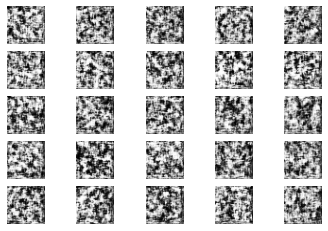

65 [D loss: 0.999971] [G loss: 1.000065]
66 [D loss: 0.999969] [G loss: 1.000065]
67 [D loss: 0.999969] [G loss: 1.000065]
68 [D loss: 0.999969] [G loss: 1.000063]
69 [D loss: 0.999970] [G loss: 1.000062]
70 [D loss: 0.999970] [G loss: 1.000064]
71 [D loss: 0.999970] [G loss: 1.000063]
72 [D loss: 0.999970] [G loss: 1.000066]
73 [D loss: 0.999970] [G loss: 1.000062]
74 [D loss: 0.999971] [G loss: 1.000063]
75 [D loss: 0.999971] [G loss: 1.000066]
76 [D loss: 0.999969] [G loss: 1.000066]
77 [D loss: 0.999969] [G loss: 1.000066]
78 [D loss: 0.999969] [G loss: 1.000065]
79 [D loss: 0.999968] [G loss: 1.000064]
80 [D loss: 0.999968] [G loss: 1.000063]
81 [D loss: 0.999969] [G loss: 1.000066]
82 [D loss: 0.999970] [G loss: 1.000065]
83 [D loss: 0.999969] [G loss: 1.000063]
84 [D loss: 0.999970] [G loss: 1.000066]
85 [D loss: 0.999971] [G loss: 1.000064]
86 [D loss: 0.999968] [G loss: 1.000064]
87 [D loss: 0.999971] [G loss: 1.000064]
88 [D loss: 0.999969] [G loss: 1.000067]
89 [D loss: 0.99

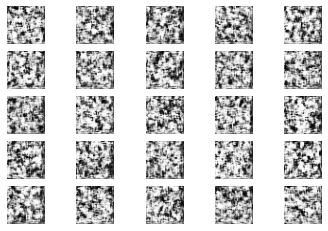

97 [D loss: 0.999971] [G loss: 1.000059]
98 [D loss: 0.999970] [G loss: 1.000063]
99 [D loss: 0.999971] [G loss: 1.000065]
100 [D loss: 0.999970] [G loss: 1.000063]
101 [D loss: 0.999970] [G loss: 1.000062]
102 [D loss: 0.999967] [G loss: 1.000063]
103 [D loss: 0.999970] [G loss: 1.000060]
104 [D loss: 0.999970] [G loss: 1.000062]
105 [D loss: 0.999971] [G loss: 1.000061]
106 [D loss: 0.999969] [G loss: 1.000055]
107 [D loss: 0.999965] [G loss: 1.000058]
108 [D loss: 0.999969] [G loss: 1.000059]
109 [D loss: 0.999971] [G loss: 1.000065]
110 [D loss: 0.999971] [G loss: 1.000059]
111 [D loss: 0.999969] [G loss: 1.000060]
112 [D loss: 0.999972] [G loss: 1.000063]
113 [D loss: 0.999970] [G loss: 1.000057]
114 [D loss: 0.999971] [G loss: 1.000058]
115 [D loss: 0.999970] [G loss: 1.000063]
116 [D loss: 0.999974] [G loss: 1.000060]
117 [D loss: 0.999972] [G loss: 1.000058]
118 [D loss: 0.999972] [G loss: 1.000057]
119 [D loss: 0.999973] [G loss: 1.000057]
120 [D loss: 0.999971] [G loss: 1.000

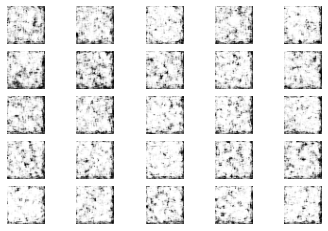

129 [D loss: 0.999981] [G loss: 1.000055]
130 [D loss: 0.999977] [G loss: 1.000056]
131 [D loss: 0.999983] [G loss: 1.000063]
132 [D loss: 0.999981] [G loss: 1.000061]
133 [D loss: 0.999987] [G loss: 1.000063]
134 [D loss: 0.999988] [G loss: 1.000067]
135 [D loss: 0.999992] [G loss: 1.000074]
136 [D loss: 0.999994] [G loss: 1.000076]
137 [D loss: 0.999996] [G loss: 1.000082]
138 [D loss: 0.999996] [G loss: 1.000078]
139 [D loss: 1.000000] [G loss: 1.000082]
140 [D loss: 1.000002] [G loss: 1.000085]
141 [D loss: 1.000004] [G loss: 1.000087]
142 [D loss: 1.000008] [G loss: 1.000097]
143 [D loss: 1.000011] [G loss: 1.000096]
144 [D loss: 1.000016] [G loss: 1.000104]
145 [D loss: 1.000018] [G loss: 1.000109]
146 [D loss: 1.000018] [G loss: 1.000110]
147 [D loss: 1.000026] [G loss: 1.000117]
148 [D loss: 1.000027] [G loss: 1.000123]
149 [D loss: 1.000034] [G loss: 1.000126]
150 [D loss: 1.000039] [G loss: 1.000133]
151 [D loss: 1.000041] [G loss: 1.000139]
152 [D loss: 1.000047] [G loss: 1.

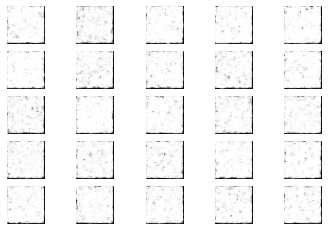

161 [D loss: 1.000111] [G loss: 1.000225]
162 [D loss: 1.000123] [G loss: 1.000238]
163 [D loss: 1.000127] [G loss: 1.000254]
164 [D loss: 1.000139] [G loss: 1.000264]
165 [D loss: 1.000150] [G loss: 1.000268]
166 [D loss: 1.000153] [G loss: 1.000292]
167 [D loss: 1.000168] [G loss: 1.000304]
168 [D loss: 1.000173] [G loss: 1.000327]
169 [D loss: 1.000183] [G loss: 1.000335]
170 [D loss: 1.000193] [G loss: 1.000355]
171 [D loss: 1.000210] [G loss: 1.000362]
172 [D loss: 1.000215] [G loss: 1.000377]
173 [D loss: 1.000222] [G loss: 1.000401]
174 [D loss: 1.000234] [G loss: 1.000416]
175 [D loss: 1.000250] [G loss: 1.000431]
176 [D loss: 1.000258] [G loss: 1.000446]
177 [D loss: 1.000259] [G loss: 1.000455]
178 [D loss: 1.000271] [G loss: 1.000474]
179 [D loss: 1.000273] [G loss: 1.000485]
180 [D loss: 1.000285] [G loss: 1.000502]
181 [D loss: 1.000290] [G loss: 1.000520]
182 [D loss: 1.000306] [G loss: 1.000542]
183 [D loss: 1.000320] [G loss: 1.000565]
184 [D loss: 1.000332] [G loss: 1.

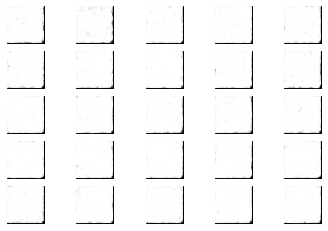

193 [D loss: 1.000411] [G loss: 1.000738]
194 [D loss: 1.000426] [G loss: 1.000742]
195 [D loss: 1.000428] [G loss: 1.000782]
196 [D loss: 1.000440] [G loss: 1.000791]
197 [D loss: 1.000458] [G loss: 1.000822]
198 [D loss: 1.000457] [G loss: 1.000835]
199 [D loss: 1.000464] [G loss: 1.000863]
200 [D loss: 1.000478] [G loss: 1.000875]
201 [D loss: 1.000489] [G loss: 1.000895]
202 [D loss: 1.000497] [G loss: 1.000921]
203 [D loss: 1.000504] [G loss: 1.000931]
204 [D loss: 1.000509] [G loss: 1.000962]
205 [D loss: 1.000512] [G loss: 1.000968]
206 [D loss: 1.000533] [G loss: 1.000990]
207 [D loss: 1.000532] [G loss: 1.001012]
208 [D loss: 1.000554] [G loss: 1.001026]
209 [D loss: 1.000563] [G loss: 1.001055]
210 [D loss: 1.000563] [G loss: 1.001072]
211 [D loss: 1.000571] [G loss: 1.001086]
212 [D loss: 1.000588] [G loss: 1.001102]
213 [D loss: 1.000588] [G loss: 1.001140]
214 [D loss: 1.000601] [G loss: 1.001136]
215 [D loss: 1.000606] [G loss: 1.001170]
216 [D loss: 1.000613] [G loss: 1.

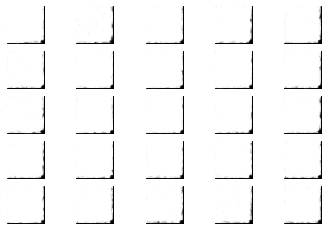

In [ ]:
# let's train the WGAN for low temperature. Again one can see improvement of the
# generator during training.
wgan_low_temp.train(epochs=225, batch_size=128, sample_interval=32)

0 [D loss: 0.999885] [G loss: 1.000200]


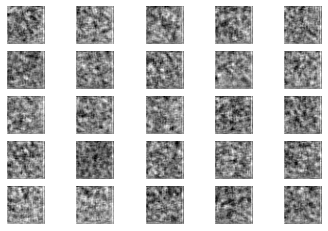

1 [D loss: 0.999890] [G loss: 1.000224]
2 [D loss: 0.999891] [G loss: 1.000229]
3 [D loss: 0.999891] [G loss: 1.000234]
4 [D loss: 0.999892] [G loss: 1.000231]
5 [D loss: 0.999891] [G loss: 1.000230]
6 [D loss: 0.999893] [G loss: 1.000228]
7 [D loss: 0.999892] [G loss: 1.000227]
8 [D loss: 0.999893] [G loss: 1.000222]
9 [D loss: 0.999895] [G loss: 1.000212]
10 [D loss: 0.999896] [G loss: 1.000205]
11 [D loss: 0.999900] [G loss: 1.000194]
12 [D loss: 0.999903] [G loss: 1.000181]
13 [D loss: 0.999908] [G loss: 1.000160]
14 [D loss: 0.999917] [G loss: 1.000143]
15 [D loss: 0.999927] [G loss: 1.000124]
16 [D loss: 0.999935] [G loss: 1.000109]
17 [D loss: 0.999944] [G loss: 1.000093]
18 [D loss: 0.999951] [G loss: 1.000085]
19 [D loss: 0.999957] [G loss: 1.000077]
20 [D loss: 0.999961] [G loss: 1.000075]
21 [D loss: 0.999965] [G loss: 1.000072]
22 [D loss: 0.999966] [G loss: 1.000069]
23 [D loss: 0.999968] [G loss: 1.000066]
24 [D loss: 0.999968] [G loss: 1.000066]
25 [D loss: 0.999969] [G 

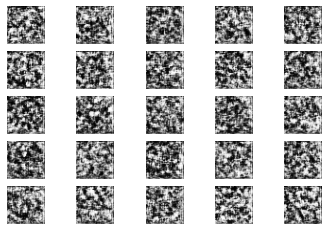

33 [D loss: 0.999971] [G loss: 1.000063]
34 [D loss: 0.999970] [G loss: 1.000064]
35 [D loss: 0.999969] [G loss: 1.000064]
36 [D loss: 0.999970] [G loss: 1.000064]
37 [D loss: 0.999971] [G loss: 1.000065]
38 [D loss: 0.999969] [G loss: 1.000065]
39 [D loss: 0.999970] [G loss: 1.000064]
40 [D loss: 0.999970] [G loss: 1.000062]
41 [D loss: 0.999970] [G loss: 1.000065]
42 [D loss: 0.999968] [G loss: 1.000065]
43 [D loss: 0.999970] [G loss: 1.000065]
44 [D loss: 0.999970] [G loss: 1.000065]
45 [D loss: 0.999969] [G loss: 1.000066]
46 [D loss: 0.999969] [G loss: 1.000066]
47 [D loss: 0.999971] [G loss: 1.000065]
48 [D loss: 0.999971] [G loss: 1.000065]
49 [D loss: 0.999970] [G loss: 1.000067]
50 [D loss: 0.999971] [G loss: 1.000065]
51 [D loss: 0.999970] [G loss: 1.000066]
52 [D loss: 0.999970] [G loss: 1.000065]
53 [D loss: 0.999969] [G loss: 1.000064]
54 [D loss: 0.999971] [G loss: 1.000064]
55 [D loss: 0.999970] [G loss: 1.000063]
56 [D loss: 0.999971] [G loss: 1.000064]
57 [D loss: 0.99

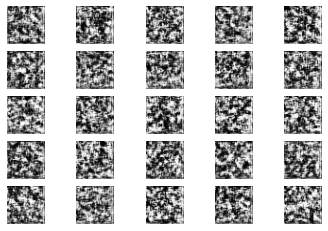

65 [D loss: 0.999971] [G loss: 1.000066]
66 [D loss: 0.999969] [G loss: 1.000064]
67 [D loss: 0.999969] [G loss: 1.000063]
68 [D loss: 0.999970] [G loss: 1.000065]
69 [D loss: 0.999970] [G loss: 1.000065]
70 [D loss: 0.999970] [G loss: 1.000065]
71 [D loss: 0.999969] [G loss: 1.000063]
72 [D loss: 0.999968] [G loss: 1.000063]
73 [D loss: 0.999971] [G loss: 1.000065]
74 [D loss: 0.999970] [G loss: 1.000064]
75 [D loss: 0.999970] [G loss: 1.000063]
76 [D loss: 0.999970] [G loss: 1.000064]
77 [D loss: 0.999968] [G loss: 1.000066]
78 [D loss: 0.999969] [G loss: 1.000063]
79 [D loss: 0.999970] [G loss: 1.000065]
80 [D loss: 0.999969] [G loss: 1.000065]
81 [D loss: 0.999971] [G loss: 1.000065]
82 [D loss: 0.999969] [G loss: 1.000064]
83 [D loss: 0.999970] [G loss: 1.000062]
84 [D loss: 0.999969] [G loss: 1.000067]
85 [D loss: 0.999970] [G loss: 1.000065]
86 [D loss: 0.999971] [G loss: 1.000065]
87 [D loss: 0.999970] [G loss: 1.000065]
88 [D loss: 0.999969] [G loss: 1.000063]
89 [D loss: 0.99

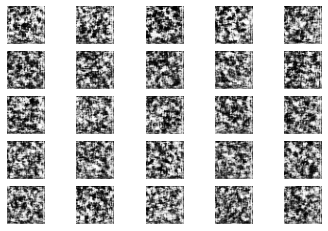

97 [D loss: 0.999971] [G loss: 1.000063]
98 [D loss: 0.999971] [G loss: 1.000064]
99 [D loss: 0.999970] [G loss: 1.000065]
100 [D loss: 0.999971] [G loss: 1.000063]
101 [D loss: 0.999970] [G loss: 1.000066]
102 [D loss: 0.999969] [G loss: 1.000066]
103 [D loss: 0.999970] [G loss: 1.000067]
104 [D loss: 0.999969] [G loss: 1.000065]
105 [D loss: 0.999970] [G loss: 1.000064]
106 [D loss: 0.999970] [G loss: 1.000066]
107 [D loss: 0.999969] [G loss: 1.000064]
108 [D loss: 0.999970] [G loss: 1.000066]
109 [D loss: 0.999970] [G loss: 1.000066]
110 [D loss: 0.999969] [G loss: 1.000064]
111 [D loss: 0.999971] [G loss: 1.000064]
112 [D loss: 0.999971] [G loss: 1.000063]
113 [D loss: 0.999970] [G loss: 1.000065]
114 [D loss: 0.999970] [G loss: 1.000062]
115 [D loss: 0.999970] [G loss: 1.000064]
116 [D loss: 0.999969] [G loss: 1.000064]
117 [D loss: 0.999971] [G loss: 1.000065]
118 [D loss: 0.999969] [G loss: 1.000066]
119 [D loss: 0.999971] [G loss: 1.000065]


In [ ]:
# let's train the WGAN for high temperature. Again one can see improvement of the
# generator during training.
wgan_high_temp.train(epochs=120, batch_size=128, sample_interval=32)

In [ ]:
# save weights (same as for GAN, though here we have critic instead of discriminator)
wgan_low_temp.generator.save_weights(path + "weights/wgan_low_temp_generator")
wgan_low_temp.critic.save_weights(path + "weights/wgan_low_temp_critic")

wgan_high_temp.generator.save_weights(path + "weights/wgan_high_temp_generator")
wgan_high_temp.critic.save_weights(path + "weights/wgan_high_temp_critic")

In [ ]:
# load weights (same as for GAN, though here we have critic instead of discriminator)
wgan_low_temp.generator.load_weights(path + "weights/wgan_low_temp_generator")
wgan_low_temp.critic.load_weights(path + "weights/wgan_low_temp_critic")

wgan_high_temp.generator.load_weights(path + "weights/wgan_high_temp_generator")
wgan_high_temp.critic.load_weights(path + "weights/wgan_high_temp_critic")

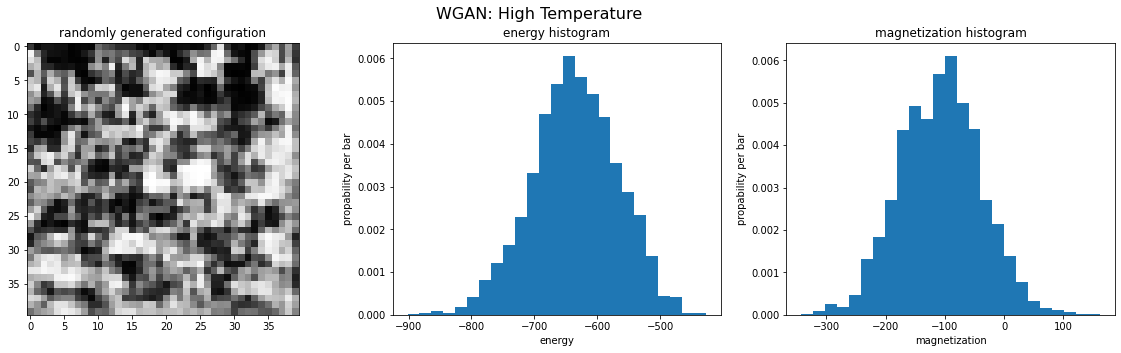

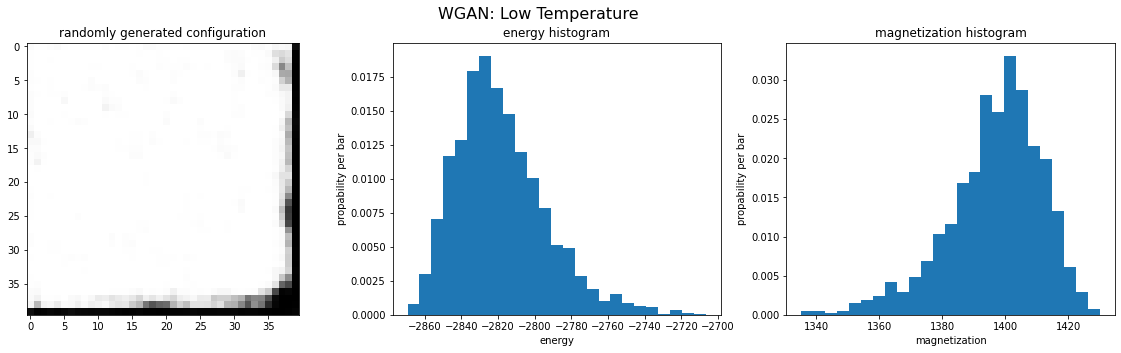

In [ ]:
plt.figure(figsize=(20, 5))
plt.suptitle("WGAN: High Temperature", size=16)
overview_generator(wgan_high_temp.generator)
plt.show()

plt.figure(figsize=(20, 5))
plt.suptitle("WGAN: Low Temperature", size=16)
overview_generator(wgan_low_temp.generator)
plt.show()

---
# Comparing Performance: GAN vs WGAN vs Dataset

Let's plot all distributions again, for better overview.

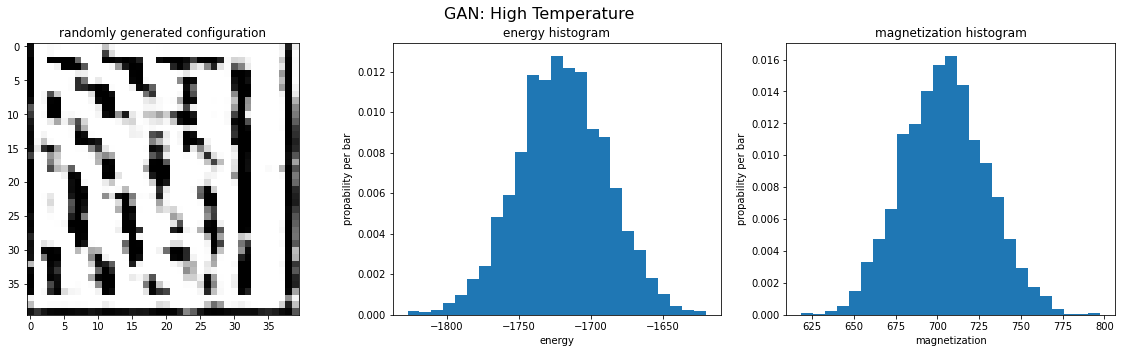

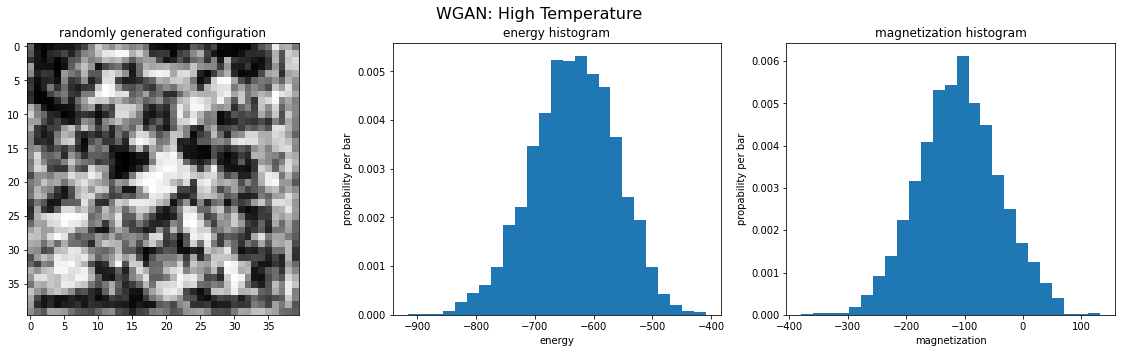

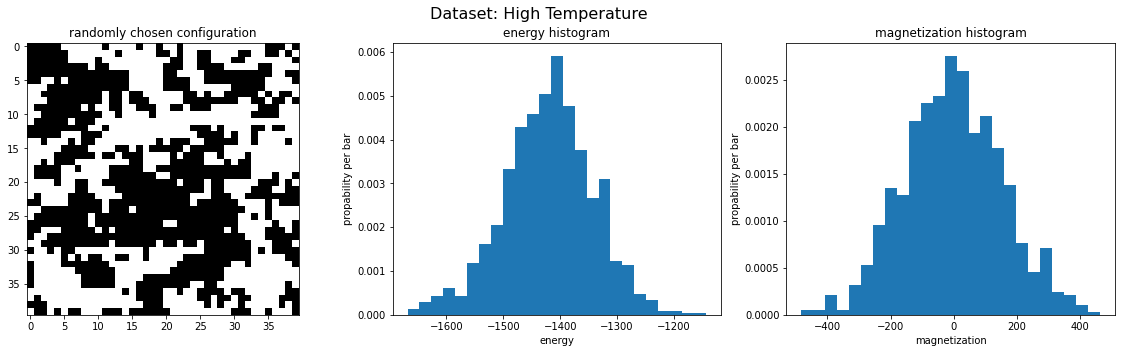

In [ ]:
plt.figure(figsize=(20, 5))
plt.suptitle("GAN: High Temperature", size=16)
overview_generator(gan_high_temp.generator)
plt.show()


plt.figure(figsize=(20, 5))
plt.suptitle("WGAN: High Temperature", size=16)
overview_generator(wgan_high_temp.generator)
plt.show()

plt.figure(figsize=(20, 5))
plt.suptitle("Dataset: High Temperature", size=16)
overview_dataset(high_temperature)
plt.show()


## Interpretaion: High Temperature

As one can see, the uncertainty of the GAN and of the WGAN is fairly high compared to the a physical Ising-Model. This can be observed due to the very blured sites of the configurations, where as in the training data, the sites have only the values $\pm 1$. However, especially the generated sample configuration of the GAN does look already quite convincing "for the human eye".

The distributions are all very similar, though with different width (std) and different mean. They all follow what looks like a gaussian distribution, which already shows impressive performance of a GAN for this case (though understandbly as the noise for the latent space for the generator is also normal distributed). We can see that the peak (and therefor the expectation value) of the training data is around $-1400$. This conforms roughly with the distribution of the GAN (with energy mean $-1740$). However, here the WGAN performs worse as here the expectation value is aroun $-650$, which is far too high.

Unfortunately, the magnetization for both, the GAN and the WGAN does not perform very well. Interestingly, the GAN has far too much magnetization in positive spin-direction (around $775$), while the WGAN has too much magnetization in negative spin-direction (around $-100$). For the training data there is in average no magnetization at all. In practice, this is visible due to too bright images (white pixel corresponds to spin-up in the configuration).

A possible way to address this issue will be explained in the outlook, at the end.


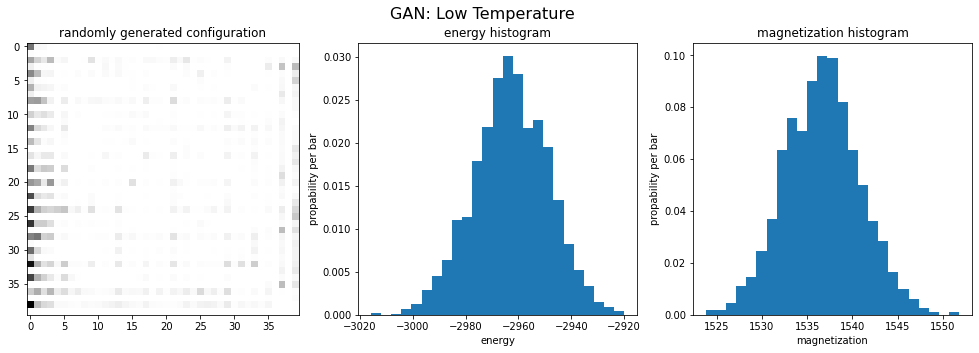

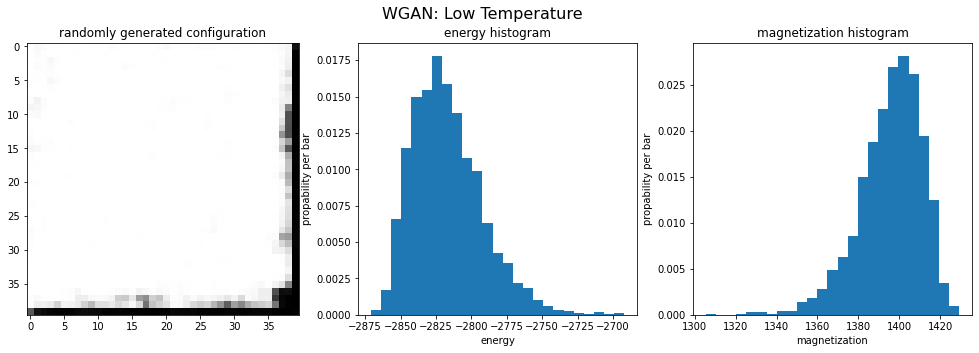

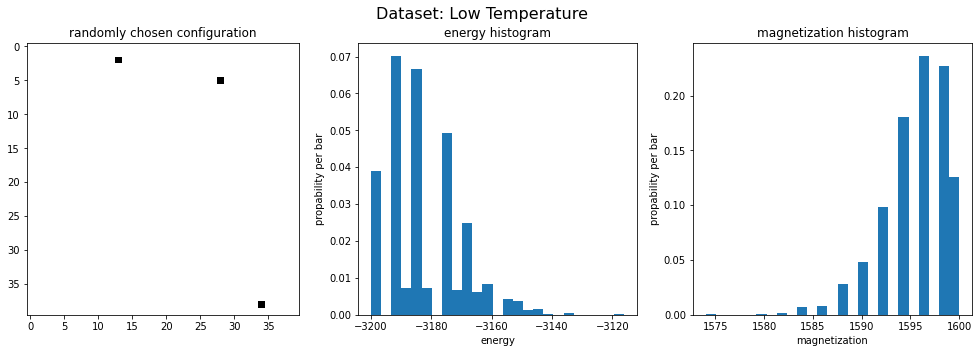

In [ ]:
plt.figure(figsize=(17, 5))
plt.suptitle("GAN: Low Temperature", size=16)
overview_generator(gan_low_temp.generator)
plt.show()

plt.figure(figsize=(17, 5))
plt.suptitle("WGAN: Low Temperature", size=16)
overview_generator(wgan_low_temp.generator)
plt.show()

plt.figure(figsize=(17, 5))
plt.suptitle("Dataset: Low Temperature", size=16)
overview_dataset(low_temperature)
plt.show()


## Interpretation: Low Temperature

Here are mostly spin-ups in the configuration visible. As explained in _Basic Datainterpretation_, this does make sense for very low temperatures. The black edges of the WGAN are very noteable. This is possible due to the architecture of the generator, trying to "trick" the discriminator. Since the interaction is being implemented using convolutional layers, there is only very little interaction at the edges of an image ($1/4$ less).

The energy mean of the GAN and the WGAN are both to a little off (in average around $-2900$) compared to the dataset (around $-3180$). However the magnetization looks to be more accurate for the GAN (with mean roughly around $1540$ for both). Further more, to me the shape of the WGAN looks better to fit the shape of the dataset, which is no longer a perfect gaussian, as it increases slower coming from the origin side (energy$=0$ or magnetization$=0$). 





## Interpretation: Both Temperatures

For both temperatures and both GAN and WGAN, the edges show different behaviour than in the middle of the image. I think this makes even more sence than the training set, as physically speaking, there is one less neighrest neighbour (only 3 instead of 4) and thus interaction is a little smaller. In the trainingset, there seem to be periodic boundary conditions. This problem could be solved by increasing the image size so that the edges become rather neglectable.

I also noticed that after each run of training, the distributions would quite differ from each other in terms of mean and width (std). This implies a strong dependence on the initial weights of the model. One would need to significantly update the loss function or the architecture to solve this problem.

# Check Performance during Training

In [ ]:
# this function compares the accuracy of a GAN (for both, low and high temperatures).
# The lower (and therefore also the more negative) the accuracy the better the 
# discriminator for given generator.
# Unfortunatly I could only implement this function for GAN due to time limitation.
def validate_gan(gan, data_set):

    number_samples = len(data_set)
    
    # 
    noise = tf.random.normal([number_samples, 100])
    generated_fake_images = gan.generator(noise, training=False)

    # comment!
    false_positive_accuracy = np.mean(gan.discriminator(generated_fake_images))

    true_positive_accuracy = np.mean(gan.discriminator(data_set))

    return false_positive_accuracy, true_positive_accuracy

print("Accuracy of high temperature GAN with test-dataset:")
print("\tgenerator: {}\ttest-dataset: {}\n".format(*validate_gan(gan_high_temp, HT_test)))
print("Accuracy of low temperature GAN with test-dataset:")
print("\tgenerator: {}\ttest-dataset: {}\n".format(*validate_gan(gan_low_temp, LT_test)))

Accuracy of high temperature GAN with test-dataset:
	generator: -1.5158801078796387	test-dataset: 2.789154052734375

Accuracy of low temperature GAN with test-dataset:
	generator: -4.89656925201416	test-dataset: 5.698362827301025



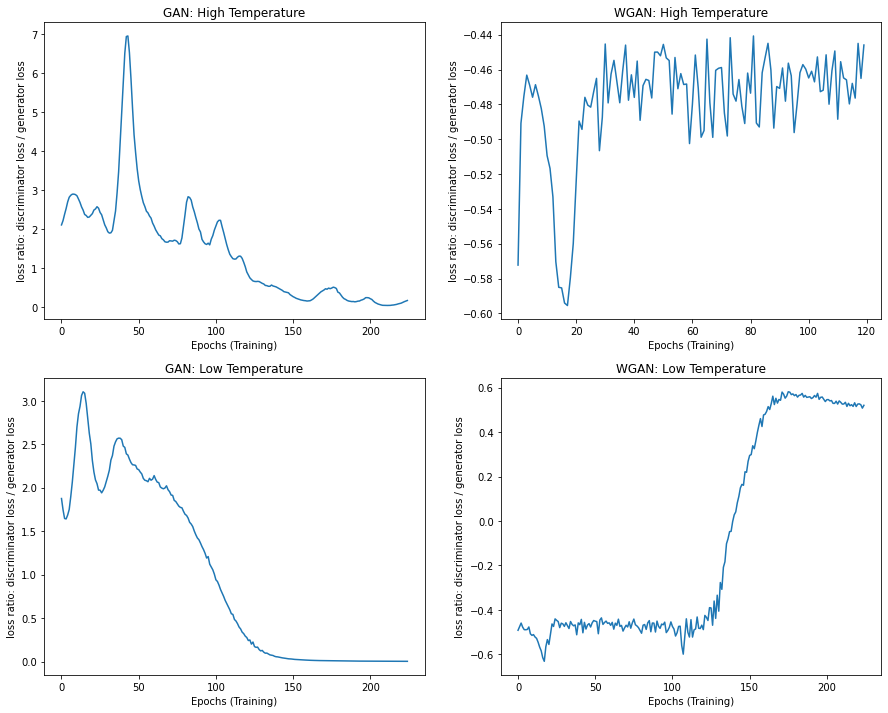

In [ ]:
# performance during training
# ratio of discriminator / generator loss

def plot_discriminator_generator_ratio(gan):
    data = gan.training_history
    plt.plot(data[:,1] / data[:,2])

plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.title("GAN: High Temperature")
plot_discriminator_generator_ratio(gan_high_temp)
plt.xlabel("Epochs (Training)")
plt.ylabel("loss ratio: discriminator loss / generator loss")

plt.subplot(2,2,2)
plt.title("WGAN: High Temperature")
plot_discriminator_generator_ratio(wgan_high_temp)
plt.xlabel("Epochs (Training)")
plt.ylabel("loss ratio: discriminator loss / generator loss")

plt.subplot(2,2,3)
plt.title("GAN: Low Temperature")
plot_discriminator_generator_ratio(gan_low_temp)
plt.xlabel("Epochs (Training)")
plt.ylabel("loss ratio: discriminator loss / generator loss")

plt.subplot(2,2,4)
plt.title("WGAN: Low Temperature")
plot_discriminator_generator_ratio(wgan_low_temp)
plt.xlabel("Epochs (Training)")
plt.ylabel("loss ratio: discriminator loss / generator loss")

plt.show()

Here one can see the ratio of the discriminator loss and the generator loss, both to be minimized. The absolute y-value is not important to understand the typical behaviour for the training process of a GAN. During training, alternately the generator and the discriminator are being optimized, each trying to become better than the other. Thereby an oscillation of both losses can become visible, which is for the GAN clearly the case. It is also interesting that for the GAN, the ratio converges finally to $0$, meaning that either the generator loss becomes very large (which does not make sense after long training) or that the discriminator loss becomes very low. In the latter case, this means that the discriminator becomes extremly accurate to differ from true configurations and fake configurations.

Regarding the WGAN, similar behaviour can be found, though it does differ! Since the lost is defined differently here, it doesn't make much sense to compare the y-values from both curves. However, it can be seen that for high temperatures, the WGAN starts to oscilate (with higher frequency) as both the discriminator and generator are already optimized. And for low temperatures, one can see easily how the generator has to learn that most spins are up (the first $120$ epochs), but then the discriminator learns to distinguish from fake configurations and thus they both converge finally.

# Problems worth discussing

The most frustrating problem I faced was furing training. For the GAN I encountered mode-collapse all the time, for low-temperatures being all spin-up configuration and for high temperatures I ended up with over repetitive configurations, which were clearly not realistic. The most important problem was to not look at extreme temperatures (being way too high, or way too low). For extremly high temperatures, the dataset looks to be completly random and is therefor very hard (theoreticly impossible?) to be learned. For extremly low temperatures, all site are spin-up which the generator could learn fairly quick. This is why I chose the temperatures $\beta_{\text{low}}=0.8 \beta_c$ and $\beta_{\text{high}}=1.8 \beta_c$ as results looked promissing. Another important fix was to increase `batch_size` from $32$ to $128$ or $256$, as thereby fluctuations during weight training became averagered.

As already commented in the code, I experimented with two (very similiar) versions of generators for the GAN:


*   `make_generator_model_Old` which did not give promising results
*   `make_generator_model` which is more general and workes better for the Ising Model



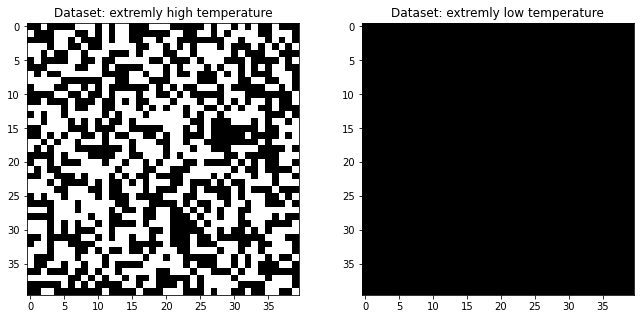

In [ ]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title("Dataset: extremly high temperature")
plt.imshow(data[0][0], cmap="gray")

plt.subplot(1,2,2)
plt.title("Dataset: extremly low temperature")
plt.imshow(data[29][0], cmap="gray")

# Outlook


Since the magnetization of the GAN and WGAN are still far off, I thought whether one could implement an additional error to the loss for high temperatures for having high (absolute) value of magnetization. This loss could be used for the discriminator. Even though this would be quite different from original (W)GANs, it should output better results. However, the great limitation is that the model will no longer be temperature-invariant and thus become less flexible. 


Wanted to compare more hyperparameters, eg. filters in convolutional layer, activation functions, dropout-rate.

I also wanted to add some droupout layers to the generator which should also prevent modal collapse (for generator) and overfitting (for discriminator).

For the GAN I wanted to clip the weights for updates. Maybe this would result in better training?

Also wanted to interpret the latent space of (W)GAN, by giving special distributions, not onlyl gaussian.

